# SART example code
|Image Size|MAC #|projection #|Method|
|------|---|---|---|
|30 by 30|3|6|SART|

In [1]:
from IPython.display import HTML, display
from PIL import Image
import io
import base64
import math
import numpy as np
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon
import cv2

In [2]:
def resize_with_aspect_ratio(img, max_size):
    width, height = img.size
    scale = min(max_size / width, max_size / height)
    new_size = (int(width * scale), int(height * scale))
    return img.resize(new_size, resample=Image.NEAREST)

def array_to_html_img_smart_resize(array, title, display_size=300):
    normalized = (array / np.max(array) * 255).astype(np.uint8)
    original_img = Image.fromarray(normalized).convert('L')
    display_img = resize_with_aspect_ratio(original_img, display_size)
    disp_buf = io.BytesIO()
    display_img.save(disp_buf, format='PNG')
    disp_b64 = base64.b64encode(disp_buf.getvalue()).decode('utf-8')
    disp_url = f"data:image/png;base64,{disp_b64}"

    return f"""
    <div class="image-container">
        <div class="image-title" style="width: {display_img.width}px;">{title}</div>
        <img src="{disp_url}" title="{title}">
        <a class="download-link" onclick="downloadImage('{disp_b64}', '{title}.png')">저장</a>
    </div>
    """

def make_image_table(arrays, titles, columns=2, display_size=300):
    assert len(arrays) == len(titles), "이미지 수와 제목 수가 같아야 합니다."
    rows = math.ceil(len(arrays) / columns)

    body_html = ""
    for r in range(rows):
        row_html = ""
        for c in range(columns):
            idx = r * columns + c
            if idx < len(arrays):
                row_html += f"<td style='text-align: center; vertical-align: top;'>{array_to_html_img_smart_resize(arrays[idx], titles[idx], display_size)}</td>"
            else:
                row_html += "<td></td>"
        body_html += f"<tr>{row_html}</tr>"

    html = f"""
   <style>
    .image-container {{
    text-align: center;
    }}
    .image-title {{
        text-align: center;
        font-size: 16px;
        font-weight: bold;
        margin-bottom: 6px;
    }}
    .download-link {{
        font-size: 12px;
        color: gray;
        background: rgba(255,255,255,0.8);
        padding: 2px 4px;
        border-radius: 4px;
        text-decoration: none;
        visibility: hidden;
        display: inline-block;
        margin-top: 4px;
    }}
    .image-container:hover .download-link {{
        visibility: visible;
    }}
    </style>


    <table style="border-collapse: collapse; float: left;">
        {body_html}
    </table>
    <script>
    function downloadImage(base64Data, filename) {{
        const link = document.createElement('a');
        link.href = 'data:image/png;base64,' + base64Data;
        link.download = filename;
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }}
    </script>

    """
    display(HTML(html))

"Image Sample <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAADeklEQVR4nO3dQYrbQBBAUU3IFfuUumSW3hihH0ktaXhvZWzigU8tikbu/CxTjfzpuvkvtj8925+pf+3lxArECsQKxArECsQKxArECn6WCcbO9/Zab9rlTVYgViBWIFYgViBWIFYgViDWMzb4ceC9I3v7dbu8yQrECsQKxArECsQKxArECsQK/i4nG19effv0yDfvdfYub7ICsQKxArECsQKxArECsQKx5p/Bjy+vvn16ne3T+HN2eZMViBWIFYgViBWIFYgViBWINWuDH5vvbe/tR3bqvd989jM2JisQKxArECsQKxArECsQKxDr2g1+5Pdm/Mp0+6+ds8ubrECsQKxArECsQKxArECsQKxZG/xY3ufIkzUmKxArECsQKxArECsQKxArEOvOX7Ie0e+Dn8tkBWIFYgViBWIFYgViBWIFYl2xwY/l/62PPLXvT/mYrECsQKxArECsQKxArECsQKxnnMGvr9nl9zJZgViBWIFYgViBWIFYgViBWFc8Bz++vNq2Tr3n/ci3OIO/gFiBWIFYgViBWIFYgViBWHeewa9nf+HOb55xum+yArECsQKxArECsQKxArECsZ72S9Z151Pofsn6i4gViBWIFYgViBWIFYgViPW0DX5sPrky9974I0xWIFYgViBWIFYgViBWIFYg1p0b/HjNPt6ZrECsQKxArECsQKxArECsQKy33gd/xIy7bUxWIFYgViBWIFYgViBWIFYg1nM3+PHqE3qTFYgViBWIFYgViBWIFYgViHXtbZLLZfdKdufcROk2yQuIFYgViBWIFYgViBWIFYj125+iGTf9XZMViBWIFYgViBWIFYgViBWI9Ya7aLY9839sNVmBWIFYgViBWIFYgViBWIFYVzxFc87zNHc58uzMh8kKxArECsQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsS69gz+Pafx55y8f5isQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsWWfwzzyNP/vk/cNkBWIFYgViBWIFYgViBWIFYs3f4Pfu7Wdv9evUe+hNViBWIFYgViBWIFYgViBWINadG/yMXX7u3v5hsgKxArECsQKxArECsQKxArGescHffwZ/NpMViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYi17PcPLws7DFt3QjcAAAAASUVORK5CYII=', 'Image Sample.png')"">저장"

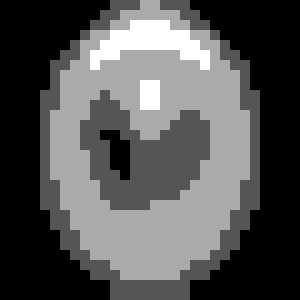

In [3]:
from random import *
num_qb = 3
nx= 30
pad = 0
num_pj = 6
phantom = shepp_logan_phantom() # 400 x 400
phantom = rescale(phantom, (nx-2)/400) 
phantom = np.pad(phantom, ((1,1),(1,1)))
sol_phantom = cv2.GaussianBlur(phantom, (7, 7), 0)
sol_phantom = sol_phantom/np.max(sol_phantom)*(num_qb) 
sol_phantom = np.round(sol_phantom, 0)

make_image_table([sol_phantom ], ["Image Sample"], columns=1)


fn_phantom = np.pad(sol_phantom, ((pad,pad),(pad,pad)))

dtheta = 180/(num_pj)
max_angle = 180
tnp = max_angle/dtheta
theta = np.arange(0, 180, dtheta)

c:\Users\KTJun\anaconda3\envs\ocean\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


"Image Sample <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAADeklEQVR4nO3dQYrbQBBAUU3IFfuUumSW3hihH0ktaXhvZWzigU8tikbu/CxTjfzpuvkvtj8925+pf+3lxArECsQKxArECsQKxArECn6WCcbO9/Zab9rlTVYgViBWIFYgViBWIFYgViDWMzb4ceC9I3v7dbu8yQrECsQKxArECsQKxArECsQK/i4nG19effv0yDfvdfYub7ICsQKxArECsQKxArECsQKx5p/Bjy+vvn16ne3T+HN2eZMViBWIFYgViBWIFYgViBWINWuDH5vvbe/tR3bqvd989jM2JisQKxArECsQKxArECsQKxDr2g1+5Pdm/Mp0+6+ds8ubrECsQKxArECsQKxArECsQKxZG/xY3ufIkzUmKxArECsQKxArECsQKxArEOvOX7Ie0e+Dn8tkBWIFYgViBWIFYgViBWIFYl2xwY/l/62PPLXvT/mYrECsQKxArECsQKxArECsQKxnnMGvr9nl9zJZgViBWIFYgViBWIFYgViBWFc8Bz++vNq2Tr3n/ci3OIO/gFiBWIFYgViBWIFYgViBWHeewa9nf+HOb55xum+yArECsQKxArECsQKxArECsZ72S9Z151Pofsn6i4gViBWIFYgViBWIFYgViPW0DX5sPrky9974I0xWIFYgViBWIFYgViBWIFYg1p0b/HjNPt6ZrECsQKxArECsQKxArECsQKy33gd/xIy7bUxWIFYgViBWIFYgViBWIFYg1nM3+PHqE3qTFYgViBWIFYgViBWIFYgViHXtbZLLZfdKdufcROk2yQuIFYgViBWIFYgViBWIFYj125+iGTf9XZMViBWIFYgViBWIFYgViBWI9Ya7aLY9839sNVmBWIFYgViBWIFYgViBWIFYVzxFc87zNHc58uzMh8kKxArECsQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsS69gz+Pafx55y8f5isQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsQKxArECsWWfwzzyNP/vk/cNkBWIFYgViBWIFYgViBWIFYs3f4Pfu7Wdv9evUe+hNViBWIFYgViBWIFYgViBWINadG/yMXX7u3v5hsgKxArECsQKxArECsQKxArGescHffwZ/NpMViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYgViBWIFYi17PcPLws7DFt3QjcAAAAASUVORK5CYII=', 'Image Sample.png')"">저장","Sinogram <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAADwAAAEsCAAAAAC6No+BAAACFElEQVR4nO2bQUsbURSFzfFGE51I2oCEimZTXLnowq78/24qFUVBEERQCxVjJdVGG9O4O29zEGRuF3LvW328zJezedx3583M3FyOHP9zNNRkm/SJdE6aklAnGSmHkE39zxppRuqRrn2SkXK0FbZO2iB1SBekoU8yUg4h2zaxRdokPZKWSCOfZKQcQravxCapK3qustYGPslIOYRsW8QJ6a/477LCvvgkI+UQsq2KevWL9ECqRIVDnWSkHEK2jji4KPVqUVS4Dz7JSDmEbKX7uiH9Exd2xbkF6iQj5RCyjcTZV6lXTXGsAZ9kpBxCthXiT/HzrZirfJKRcgjZWmKX/CMuLLWu75OMlEPIVk63Tkn34v5ygTT2SUbK0U4rPpLOxP1l6f6nPslIOdq9ZJ+0LPbGZ1LXJxkph5DtWnTwy+Ip91Q8oUSdZKQcQrax2BEr8aZY2UPnfZKRcgjZJmLlVGJd9URHhjrJSDnaLtkW+2BH7JINn2SkHEK29qu1qSPmJj7JSDlaH7ZAaok7yLL+Gj7JSDmEbD+In8WZfqlXZYx9kpFytD5sRby98yQqXOWTjJRDyHZEbItdsiE6/TufZKQcQrZv4m3DHdGHlf3y0icZKYeQbU+c5G+LudLp7/okI+Vo30sekw5JA/F1yHefZKQcbYUNSQek36L7P/FJRsrRVtiMtC/mrsSXSKiTjJTfNt6p/AIsJ1NnOdMYIgAAAABJRU5ErkJggg==', 'Sinogram.png')"">저장"

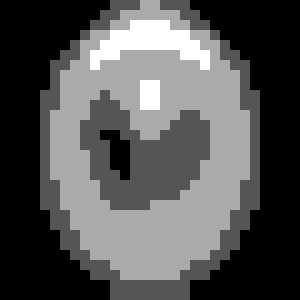
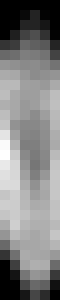

In [4]:
from random import *
sino = radon(fn_phantom, theta)
make_image_table([fn_phantom, sino], ["Image Sample", "Sinogram"], columns=2)

In [ ]:
random_matrix = np.random.uniform(0.95, 1.05, size=(nx+2*pad, num_pj))
noisy_sinogram = sino*random_matrix

"CT image using sart <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAAHw0lEQVR4nO2dS0+cZRiGP6DAAOXUFqzY1FOsiWlN3Bo37ox7f5B7f4Bb/4iJCxMXJkYTjbWJra0t5VSgFIZDmXH3vpsrn9wM4CHXtXoCM998c/Eu7nl43neaRkRERERE/jsMXezLjZVqvlTTpXpZqsulega3+rxUu6XqNefP8AW8xv8GZQUoK0BZAcoKUFaAsgKUFaCsfzLBD5VqolQflOrTUs2W6naplkp1tVRrpfq9VN+X6m6pvoPH9ZuzxZUVoKwAZQUoK0BZAcoKUFaAsgKUdfEJ/lKpbpXq81J9DD3z+oxD6NDXx42Xqgs9+JVSbZbqx1J9Var15ixwZQUoK0BZAcoKUFaAsgKUFaCsAGVdVIKfLNVnpfqiVNdKtQ/Zu3IPHleZgsmaK9Chr5n/CPL9l6X6ZoC5G1dWgLIClBWgrABlBSgrQFkBygpQVkBthZ+YuVJ9AtMxNTWPQrp+UqqfS3UAf7kJ6NDX3P5HqRZK9VqpluHKH8Ib/rZUe83JcGUFKCtAWQHKClBWgLIClBWgrABlnUeCny7VdUjN9TIbkNsfQJe9C/l5CxL8CDzulVLdL9UxVH24v1p14Bk18xOurABlBSgrQFkBygpQVoCyApQVoKzzSPCTpboJEy41K+9Av/0QEvILSOvTMNxTZ+MbeO5MqR7D9bpwpz14R9vwurQL1pUVoKwAZQUoK0BZAcoKUFaAsgKUNWiCH4LkOwEnxtR0/RTmWubgREjayVqz8g147gbk8S2YrNmFO5iATxMdWCfH8H734P5cWQHKClBWgLIClBWgrABlBSgrQFmDJvhhyPLzkGiHIDX3YIfqMlx5DmZxhmDS/RDmaWqW/xX+M7AMe18P4Mx5mpjZhU8n9Q5cWQHKClBWgLIClBWgrABlBSgrQFmDJvhLcK7LDPS9FyDldmH6/QGcT3MNdrwewJk196FD/zacAj/Ves8LcA79NOy+rThFMyDKClBWgLIClBWgrABlBSgrQFmnS/BDrVMlHehsU3e6Jvg/4WfbcBZNt3Ui/ia82tewM3YdnlGT+SJ8/qj5njiC9+bKClBWgLIClBWgrABlBSgrQFkByho0wTeQ5Sfg+1LHYf/qOsyr1FmXd+HVVuGzAe1G7UOvvk7W/FSqV2Fifxfyff0M0U6dC3JlBSgrQFkBygpQVoCyApQVoKwAZZ0uwfchs76ExD0Msyk7sGt1Dc6JGYEsPwcd9SNI8Edw08OQ1n8r1R2Yal+EzwuX4P0SrqwAZQUoK0BZAcoKUFaAsgKUFaCsQXvwlOCnoD9+DD3uDTjz8R2YhFlu7cHfgCtvQ+av93wL7m8HEnydsH8TZuPr3ROurABlBSgrQFkBygpQVoCyApQVoKzTJfjh1rmRPvTCtyF7T0NXfAsy9QbMo3ehV1/v5T34bLAJyXwJrlfz/Q/w22HYVVvfZcWVFaCsAGUFKCtAWQHKClBWgLIClDXoFE0DPfMh+Bml3CVI10eQkJ9CWu9AX34ErjcM/xmg03AmYI5npvXunaI5M5QVoKwAZQUoK0BZAcoKUFaAss7jO1nXISvPQ1d8Ec50H4GXW4JZnFm43hx0/Keg978IGX0CzrO8DHP6XZi2odPiXVkBygpQVoCyApQVoKwAZQUoK0BZg/bg6RudtmH+ZQweNwaTK0/gce/DlWs1Cbtbl6AahemdMfhe1covMGFPp9w0rXt45W9RVoCyApQVoKwAZQUoK0BZAco6ux58D/rUj+A0yTlIw7VD/zpk9BG4ygP4zqZDeI0Z6N83kMxXIYWvQZ+/PoPE1NdwZQUoK0BZAcoKUFaAsgKUFaCsAGWdLsH3YB59H7rTOyc8f7L+9jZ04/twvY/gDibhE8E89OA7kMdHIbcft3boaRXVd+TKClBWgLIClBWgrABlBSgrQFkByhq0B097Wp/CSY+PYQp9Fr4RtQfPrZ8IrkMKvw/foXoFbroHM+8jkNafwf7Vep5lA88lB66sAGUFKCtAWQHKClBWgLIClBWgrEET/CHMlG9CX34Petx9yOMvIGevQILvwycCOqF9Frrx9N+CFZiied468151uJN1QJQVoKwAZQUoK0BZAcoKUFaAss6uB08TJPdaz6KZgn72KPxsBtJ/A1dp4BSZHpyQU1+jgXmaQ5i1r1dp4HGEKytAWQHKClBWgLIClBWgrABlBSjrPHayduD7mVahK34VTow5gIT8Fuxu3YRXm4Gf0Zz+ENxfnZh5CDty+yDB8+DPDGUFKCtAWQHKClBWgLIClBWgrPM4D34fzo5ZhXNixqHfvgA/W4bu+ThMsB/AHYzCJ4ya1u/CifSP4Mq0+7YdV1aAsgKUFaCsAGUFKCtAWQHKClDWeST4BjL1Q3A+B/l5DeZuFqEr3oWcPQ6/3YFJ9xXo5K/C9Pt263eytuPKClBWgLIClBWgrABlBSgrQFkBygqowydndJmZUt0p1RvwvUs0dzPdmuV34EzKJ5DWtyDV77aeIH9SXFkBygpQVoCyApQVoKwAZQUoK0BZF5/g2y9d+/I34VSaK7BXtQM98x04n2YdfrsXT8ecFFdWgLIClBWgrABlBSgrQFkBygpQ1r8jwbf/bTowJzMMp1jSztN9mIShk2XOGldWgLIClBWgrABlBSgrQFkBygpQVnNy/gKelmCPLKo64gAAAABJRU5ErkJggg==', 'CT image using sart.png')"">저장","Error <a class=""download-link"" onclick=""downloadImage('iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAAAAABcFtGpAAAIMklEQVR4nO2d2W4dZRZG65jYTuLExKFjIECADoEWQyBMDUEMgRuGB+BR+kn6JVpq9RURBBqpuxklJgECAnTTBBKGkJjEJE6MB+72f7NU8ufjYwlpratPx3ZVefm/2LW966/BX7vN5IXerx6Fz57t/Ynnus1kbFPP9jtHWQHKClBWgLIClBWgrABlBSgrYLAZFfzRShOV3qi0s9JSpR2VzlYaVHq00oVKT3ejx5UVoKwAZQUoK0BZAcoKUFaAsgKUFbCl22AGlV6tdBi+76lKJypdW+mqSj9V+lOldyrdUukt+L7VbmNxZQUoK0BZAcoKUFaAsgKUFaCsAGVtfgW/pdIXlZ6vdKTS3+Anbqw0XulMpa2VPq20Av37+ytdX+k03AcMgysrQFkBygpQVoCyApQVoKwAZQUoa7Mq+O2Vpir9pdIfKv290jboj39V6TKcYwoma/ZW+rDSE5V+hRn6byr9C+4D1oorK0BZAcoKUFaAsgKUFaCsAGUFKGu0FfyuSsuVnqn0daWXK/1S6VSlmyCNQaW/WGl3pWOV9lT6oNK9cEcwB9M7r1e62K0NV1aAsgKUFaCsAGUFKCtAWQHKClDWKCr4nZXeg51gjkHn/bNKd1SahKq5pZ+hgr8Cvu8I3EN8VOkg7HzTZuNfgitt3fhLXR+urABlBSgrQFkBygpQVoCyApQVoKxR7EVzdaWTMK1+EObW56GP3rri56BavwjPw05ALd8ma6ahCm/H+7bSebi+Nn//HRyFnoJ1ZQUoK0BZAcoKUFaAsgKUFaCsAGUN24MfwOz5NphCbzX69zDXsgt2hLwAJ16FqfYrKz1UaQF69bvhyHvgmk/Bkcegkz8FdxPt+lxZAcoKUFaAsgKUFaCsAGUFKCtAWcNW8GTwTei3D6BqXoFdaQ5VehHq++tgL5o2TX8r9OAXYFJnH3TUd0Dvv1Xr/6h0H9wHTMB/EFxZAcoKUFaAsgKUFaCsAGUFKCtAWcNW8FtgX5edlWagbl+E6rpNvx+v9GCl/0HdvgxTL5/CLpH7YRf4KbjmabjSK6G+J5yi
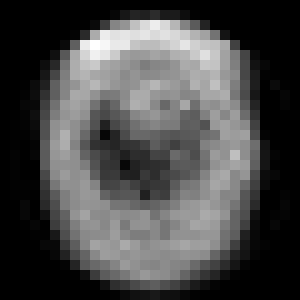
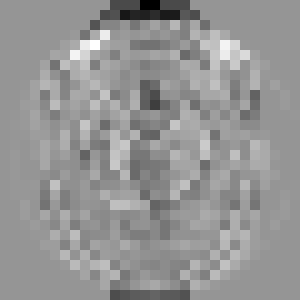

Error of solution:  168.75774943414808
Variance of solution:  377.1266669241806


In [6]:
from skimage.transform import iradon_sart
reconstruction_sart = iradon_sart(noisy_sinogram, theta=theta)
for i in range(5):
    reconstruction_sart = iradon_sart(noisy_sinogram, theta=theta, image = reconstruction_sart)
reconstruction_sart[np.where(reconstruction_sart<0)] = 0 

Error  = reconstruction_sart-sol_phantom
make_image_table([reconstruction_sart, Error-np.min(Error)], ["CT image using sart", "Error"], columns=2)

print("Error of solution: ", np.sum(np.abs(reconstruction_sart-sol_phantom)))
sol_var_x = np.abs(np.diff(reconstruction_sart))
sol_var_y = np.abs(np.diff(reconstruction_sart, axis=0))
print("Variance of solution: ", np.sum(sol_var_x)+np.sum(sol_var_y))